In [1]:
import re
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import json
from pylab import *
import pandas as pd
from dogues_functions_2 import clean_article_name, plot_category_trends, fetch_pageview_count, normal_data, extract_clean_text, fetch_and_combine_pageview_data, scrape_wikipedia_sub_subheadings_with_links, fetch_pageview_count_dates, fetch_viewcount_df


# Loading the data from milestone 2 

In [2]:
#load data into df
df_fakecovidNews = pd.read_csv('./Data/covid-19_misinformation5.csv')

In [16]:
def getSubLinksFromIntro(website, nombreMax=10):
    link = "https://en.wikipedia.org/wiki/"+website

    #load online the html file 
    r = requests.get(link)
    soup = BeautifulSoup(r.text, 'html.parser')

    intro = soup.find_all('div', attrs={'class':'mw-content-ltr mw-parser-output'})[0].find_all('p')
    #get the all the href
    links = []
    for i in intro:
        #get the link and not the <a> tag
        try:
            currentLink = i.find_all('a', href=True)[0]['href']
            if(currentLink[0] == '#'):
                continue
            links.append(currentLink)
        except:
            pass

        if(len(links) >= nombreMax):
            break
    
    return links

In [17]:

 
def existed(article, dateMin="2020-03-01"):
    #check if the first timestamp is less dateMin 
    if pd.Timestamp(article.iloc[0]['timestamp']) <= pd.Timestamp(dateMin):
        return True
    else:
        return False  


def getSubLinksFromIntroPablo(links):
    views = []
    for link in links:
        result = fetch_pageview_count("en", link)
        if(len(result) != 0):
            views.append(result)

    return views[0]



In [87]:
#make subplot of all the views of dfViewFinal
def plotAllInfos(topic, function):

    fig, axs = plt.subplots(len(topic.dfViewFinal)//3 + 1, 3, figsize=(15, len(topic.dfViewFinal)), sharex=True)
    for i in range(len(topic.dfViewFinal)):
        plt.xticks(rotation=45)
        axs[i//3, i%3].plot(topic.dfViewFinal[i]['timestamp'], function(topic.dfViewFinal[i]['views']))
        axs[i//3, i%3].set_title(topic.dfViewFinal[i]['article'].unique()[0])

        #axs[i].set_title(topic.dfViewFinal[i]['article'])
        #make rotation of x axis
        axs[i//3, i%3].set_ylabel('Views')
        axs[i//3, i%3].set_xlabel('Date')


    #make subplot of all the views of dfViewSubLinksFinal
    fig, axs = plt.subplots(len(topic.dfViewSubLinksFinal)//3+1, 3, figsize=(15, len(topic.dfViewSubLinksFinal)), sharex=True)
    for i in range(len(topic.dfViewSubLinksFinal)):
        plt.xticks(rotation=45)
        axs[i//3, i%3].plot(topic.dfViewSubLinksFinal[i]['timestamp'], function(topic.dfViewSubLinksFinal[i]['views']))
        axs[i//3, i%3].set_title(topic.dfViewSubLinksFinal[i]['article'].unique()[0])
        #axs[i].set_title(topic.dfViewFinal[i]['article'])
        #make rotation of x axis
        axs[i//3, i%3].set_ylabel('Views')
        axs[i//3, i%3].set_xlabel('Date')


def plotMainInfos(topic, function):
    fig, axs = plt.subplots(len(topic.dfViewFinal)//3 + 1, 3, figsize=(15, len(topic.dfViewFinal)), sharex=True)
    for i in range(len(topic.dfViewFinal)):
        plt.xticks(rotation=45)
        axs[i//3, i%3].plot(topic.dfViewFinal[i]['timestamp'], function(topic.dfViewFinal[i]['views']))
        axs[i//3, i%3].set_title(topic.dfViewFinal[i]['article'].unique()[0])

        #axs[i].set_title(topic.dfViewFinal[i]['article'])
        #make rotation of x axis
        axs[i//3, i%3].set_ylabel('Views')
        axs[i//3, i%3].set_xlabel('Date')


def getViewsNormalizedTotal(topic, function):
    dftemp = topic.dfViewFinal.copy()

    columns = ["timestamp", "viewNormalized"]
    newdf = pd.DataFrame(columns=columns)

    for i in range(len(topic.dfViewFinal)):
        dftemp[i]["viewNormalized"] = function(topic.dfViewFinal[i]['views'])
        newdf = pd.concat([newdf, dftemp[i][["timestamp", "viewNormalized"]]], ignore_index=True)

    newdf = newdf.groupby("timestamp").sum()

    return newdf
    



def getInfoByArticles(df):
    columns = ["article", "views"]
    newdf = pd.DataFrame(columns=columns)

    for i in range(len(df)):
        newdf = pd.concat([newdf, df[i][["article", "views"]]], ignore_index=True)

    mean = newdf.groupby("article").mean()
    median = newdf.groupby("article").median()
    std = newdf.groupby("article").std()



    #rename the columns
    mean.columns = ["mean"]
    median.columns = ["median"]
    std.columns = ["std"]
    newdf = pd.concat([mean, median, std], axis=1)


    return newdf

 Functions for normalization of the data (ex relative increase ect ect)

In [19]:

def standarization(array):
    return (array - np.mean(array)) / np.std(array)

def minMax(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

def nonefunction(array):
    return array

In [89]:
class wikiTopic:
    df = []

    links = []
    dfView = []
    dfViewFinal = []

    dfSubLinks = []
    dfViewSubLinks = []
    dfViewSubLinksFinal = []

    def __init__(self, df, Maintopic):

        self.dfView = []
        self.dfViewFinal = []
        self.dfViewSubLinks = []
        self.dfViewSubLinksFinal = []
        
        indexes = df["Main Heading"]==Maintopic
        self.df = df[indexes]

        self.extractLinksFromDf()
        self.getViews()

        self.getSublinks()
        #self.getViewsSubLinks()

    def extractLinksFromDf(self):

        linksFinal = []
        for links in self.df.Links:
            links = links[1:-1]
            links = links.split(',')

            links = [re.sub(r'[\[\]\'\s]', '', link) for link in links]
            links = [re.sub(r'/wiki/', '', link) for link in links]
            #concatenate the list
            linksFinal = linksFinal + links
        
        self.links = list(set(linksFinal))

    def getViews(self):
        #fetch view counts
        viewsdf = getSubLinksFromIntroPablo([self.links])
        keys = list(viewsdf.keys())
        #make a list of df 
        for i in range(len(keys)):
            if(existed(viewsdf[keys[i]])):
                self.dfViewFinal.append(viewsdf[keys[i]])
            self.dfView.append(viewsdf[keys[i]])
            
    

    def getSublinks(self):
        for i in range(len(self.links)):
            allSublinks = getSubLinksFromIntro(self.links[i])
            allSublinks = [re.sub(r'/wiki/', '', link) for link in allSublinks]
            #if the sublinks have "#cite_" remove them 
            allSublinks = [link for link in allSublinks if "#cite_" not in link]
            self.dfSubLinks = self.dfSubLinks + allSublinks

        self.dfSubLinks = list(set(self.dfSubLinks))

    def getViewsSubLinks(self):
        #fetch view counts
        viewsdf = getSubLinksFromIntroPablo(self.dfSubLinks)
        keys = list(viewsdf.keys())
        #make a list of df 
        for i in range(len(keys)):
            if(existed(viewsdf[keys[i]])):
                self.dfViewSubLinksFinal.append(viewsdf[keys[i]])
            self.dfViewSubLinks.append(viewsdf[keys[i]])




In [90]:
df_fakecovidNews["Main Heading"].unique()


array(['Virus origin', 'Incidence and mortality', 'Disease spread',
       'Prevention', 'Treatment', 'Other',
       'Efforts to combat misinformation'], dtype=object)

In [69]:
topic = wikiTopic(df_fakecovidNews, "Virus origin")

In [81]:
len(topic.links)

173

In [82]:
topic.getViews()

Error fetching data for Misinformation_related_to_the_COVID-19_pandemic#Misinformation_regarding_virus_origin. Status Code: 404
Error fetching data for _Russia. Status Code: 404
Error fetching data for Biosafety_level#Biosafety_level_4. Status Code: 404
Error fetching data for List_of_conspiracy_theories#RFID_chips. Status Code: 404


In [95]:
meinDF = topic.dfViewFinal[0]

In [101]:
#group the  timestamp by mounth
meinDF.groupby(pd.Grouper(key='timestamp', freq='M'))["views"].sum()


timestamp
2019-01-31     147657
2019-02-28     117429
2019-03-31     285642
2019-04-30     172934
2019-05-31     106913
2019-06-30      72090
2019-07-31     301410
2019-08-31     296948
2019-09-30     103676
2019-10-31     137094
2019-11-30     148677
2019-12-31     172466
2020-01-31     209315
2020-02-29     231223
2020-03-31    1014908
2020-04-30    1251264
2020-05-31     994289
2020-06-30    1039306
2020-07-31    2704497
2020-08-31    4125721
2020-09-30    1633773
2020-10-31    2778665
2020-11-30    1526658
2020-12-31     608537
2021-01-31    4676752
2021-02-28    1444330
2021-03-31     800084
2021-04-30     603114
2021-05-31     419657
2021-06-30     512421
2021-07-31     293584
2021-08-31     475763
2021-09-30     303694
2021-10-31     272150
2021-11-30     406604
2021-12-31     366927
2022-01-31     325250
2022-02-28     270486
2022-03-31     251452
2022-04-30     237534
2022-05-31     177828
2022-06-30     184167
2022-07-31     183600
2022-08-31     231374
2022-09-30     471691


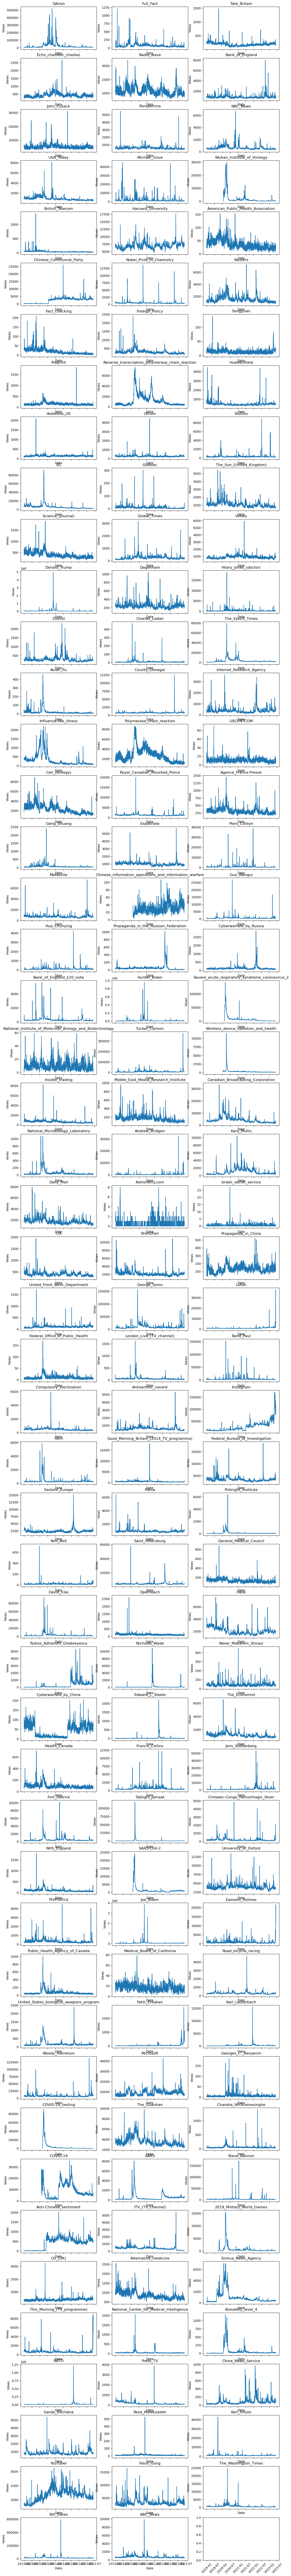

In [88]:
plotMainInfos(topic, nonefunction)

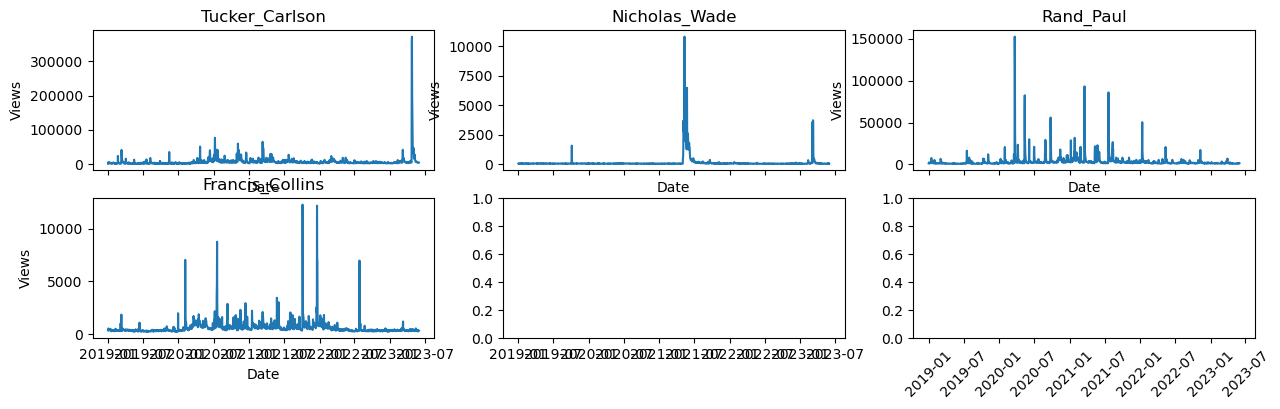

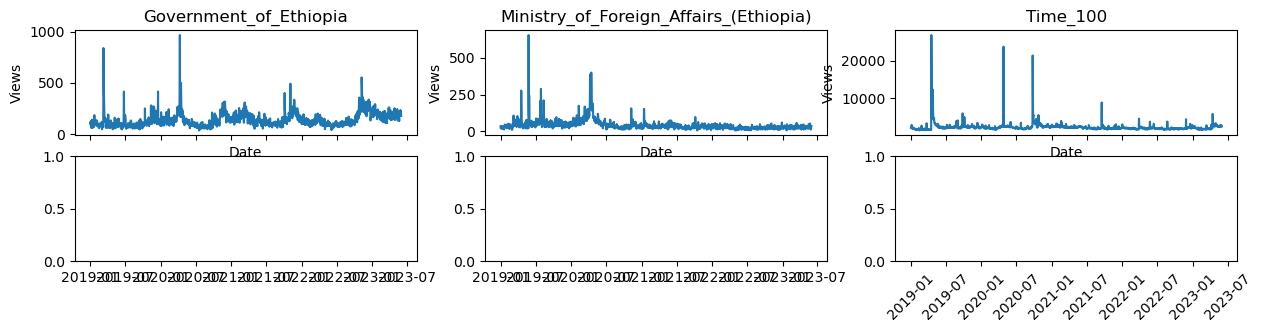

In [508]:
plotAllInfos(topic, nonefunction)

C:\Users\pablo\AppData\Local\Temp\ipykernel_8036\3824554915.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  newdf = pd.concat([newdf, dftemp[i][["timestamp", "viewNormalized"]]], ignore_index=True)


<Axes: xlabel='timestamp'>

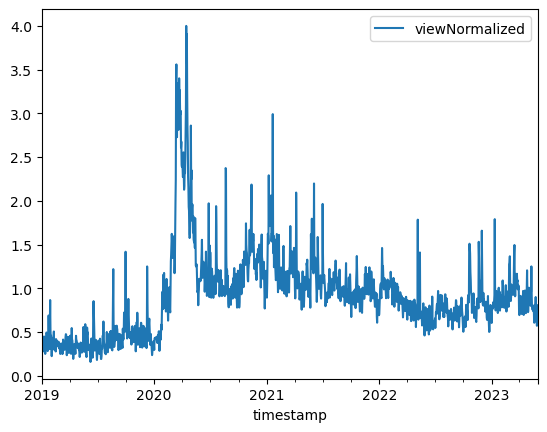

In [342]:
getViewsNormalizedTotal(topic, minMax).plot()

In [509]:
topic = wikiTopic(df_fakecovidNews, 1)

Error fetching data for Misinformation_related_to_the_COVID-19_pandemic#Misinformation_regarding_virus_origin. Status Code: 404
Error fetching data for /w/index.php?title=DNA_genomes&action=edit&redlink=1. Status Code: 404
Error fetching data for /w/index.php?title=Virome_diversity&action=edit&redlink=1. Status Code: 404


In [510]:
print(topic.df["Sub-subheading"])

getInfoByArticles(topic.dfView)

Bio-weapon


,mean,median,std
article,,,
Andrew_Bridgen,303.954715,93.0,1041.370149
Anti-Chinese_sentiment,406.932382,493.5,299.475216
Biosafety_level_4,55.277295,20.0,134.032170
Chinese_Communist_Party,2256.523573,2846.5,1846.396661
Echo_chamber_(media),440.887097,420.0,144.742039
Expatriate,1010.801489,981.0,272.988783
Falun_Gong,3179.132134,2841.0,1343.540557
Fort_Detrick,448.114764,302.5,554.508514
Guo_Wengui,559.062035,337.0,1113.215089


In [511]:
topic = wikiTopic(df_fakecovidNews, 2)

Error fetching data for /w/index.php?title=DNA_genomes&action=edit&redlink=1. Status Code: 404
Error fetching data for /w/index.php?title=Virome_diversity&action=edit&redlink=1. Status Code: 404
Error fetching data for /w/index.php?title=DNA_genomes&action=edit&redlink=1. Status Code: 404
Error fetching data for /w/index.php?title=Virome_diversity&action=edit&redlink=1. Status Code: 404


In [512]:
print(topic.df["Sub-subheading"])

getInfoByArticles(topic.dfView)

Gain-of-function research


,mean,median,std
article,,,
Angela_Rasmussen,42.408304,29.0,57.701045
Chimeric_virus,0.72402,1.0,0.917493
Francis_Collins,605.313896,442.5,690.336084
Gain-of-function_research,634.116898,315.0,1236.438714
Nicholas_Wade,117.177419,43.0,477.985603
Ralph_Baric,2.92375,2.0,2.885454
Rand_Paul,3454.568238,1842.5,7677.207855
Tucker_Carlson,7737.588089,5080.5,15570.257244


In [515]:
getInfoByArticles(topic.dfViewSubLinks)

,mean,median,std
article,,,
Government_of_Ethiopia,141.117246,123.0,71.448622
Ministry_of_Foreign_Affairs_(Ethiopia),41.904467,33.0,35.565270
Ministry_of_Health_(Ethiopia),15.924464,11.0,19.349990
Time_100,2252.885856,2055.5,1255.909307


In [513]:
topic = wikiTopic(df_fakecovidNews, 3)

Error fetching data for /w/index.php?title=DNA_genomes&action=edit&redlink=1. Status Code: 404
Error fetching data for /w/index.php?title=Virome_diversity&action=edit&redlink=1. Status Code: 404
Error fetching data for /w/index.php?title=DNA_genomes&action=edit&redlink=1. Status Code: 404
Error fetching data for /w/index.php?title=Virome_diversity&action=edit&redlink=1. Status Code: 404


In [514]:
print(topic.df["Sub-subheading"])

getInfoByArticles(topic.dfView)

Accidental release of collected sample


,mean,median,std
article,,,
Science_(journal),409.287221,375.5,151.077270
Tedros_Adhanom_Ghebreyesus,268.77095,42.0,487.574544
